# 1. Install all the Required Libraries
### Start by installing Gradio if it's not already installed.

In [1]:
! pip install gradio
! pip install cv
! pip install ultralytics
! pip install google-generativeai
! pip install paddleocr
! pip install paddlepaddle

# 2. Import Libraries
### Getting all the necessary Libraries

In [2]:
import gradio as gr
import random
import numpy as np
from PIL import Image
import cv2
import time
from ultralytics import YOLO
import pandas as pd
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt
import google.generativeai as genai
from google.colab import userdata
from datetime import datetime
from paddleocr import PaddleOCR
from google.colab import files

# 3. Import Drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. Brand Recognition Backend



### Image uploading for Grocery detection

In [4]:
def detect_grocery_items(image):
    model = YOLO('kitkat_s.pt')
    image = np.array(image)[:, :, ::-1]
    results = model(image)
    annotated_image = results[0].plot()

    class_ids = results[0].boxes.cls.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()

    threshold = 0.4
    class_counts = {}
    class_confidences = {}

    for i, class_id in enumerate(class_ids):
        confidence = confidences[i]
        if confidence >= threshold:
            class_name = model.names[int(class_id)]

            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1

            if class_name in class_confidences:
                class_confidences[class_name].append(confidence)
            else:
                class_confidences[class_name] = [confidence]

    if not class_counts:
        return image, [], "The model failed to recognize items or the image may contain untrained objects."

    summary_table = [[class_name, count, f"{np.mean(class_confidences[class_name]):.2f}"]
                     for class_name, count in class_counts.items()]

    annotated_image_rgb = annotated_image[:, :, ::-1]
    return annotated_image_rgb, summary_table, "Object Recognised Successfully 🥳 "


### Detect Grovcery brand from video

In [5]:
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection / float(area1 + area2 - intersection)
    return iou

In [6]:
def smooth_box(box_history):
    if not box_history:
        return None
    return np.mean(box_history, axis=0)

In [7]:
def process_video(input_path, output_path):
    model = YOLO('kitkat_s.pt')
    cap = cv2.VideoCapture(input_path)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    detected_items = {}
    frame_count = 0

    detections_history = defaultdict(lambda: defaultdict(int))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        if frame_count % 5 == 0:
            results = model(frame)

            current_frame_detections = []

            for r in results:
                boxes = r.boxes
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    conf = box.conf.item()
                    cls = int(box.cls.item())
                    brand = model.names[cls]

                    current_frame_detections.append((brand, [x1, y1, x2, y2], conf))

            for brand, box, conf in current_frame_detections:
                matched = False
                for item_id, item_info in detected_items.items():
                    if iou(box, item_info['smoothed_box']) > 0.5:
                        item_info['frames_detected'] += 1
                        item_info['total_conf'] += conf
                        item_info['box_history'].append(box)
                        if len(item_info['box_history']) > 10:
                            item_info['box_history'].popleft()
                        item_info['smoothed_box'] = smooth_box(item_info['box_history'])
                        item_info['last_seen'] = frame_count
                        matched = True
                        break

                if not matched:
                    item_id = len(detected_items)
                    detected_items[item_id] = {
                        'brand': brand,
                        'box_history': deque([box], maxlen=10),
                        'smoothed_box': box,
                        'frames_detected': 1,
                        'total_conf': conf,
                        'last_seen': frame_count
                    }

                detections_history[brand][frame_count] += 1


        for item_id, item_info in list(detected_items.items()):
            if frame_count - item_info['last_seen'] > fps * 2:  # 2 seconds
                del detected_items[item_id]
                continue

            if item_info['smoothed_box'] is not None:
                alpha = 0.3
                current_box = item_info['smoothed_box']
                target_box = item_info['box_history'][-1] if item_info['box_history'] else current_box
                interpolated_box = [
                    current_box[i] * (1 - alpha) + target_box[i] * alpha
                    for i in range(4)
                ]
                item_info['smoothed_box'] = interpolated_box

                x1, y1, x2, y2 = map(int, interpolated_box)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"{item_info['brand']}",
                            (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()

    total_frames = frame_count
    confirmed_items = {}
    for brand, frame_counts in detections_history.items():
        detection_frames = len(frame_counts)
        if detection_frames > total_frames * 0.1:
            avg_count = sum(frame_counts.values()) / detection_frames
            confirmed_items[brand] = round(avg_count)

    return confirmed_items

In [8]:
def annotate_video(input_video):
    output_path = 'annotated_output.mp4'
    confirmed_items = process_video(input_video, output_path)

    item_list = [(brand, quantity) for brand, quantity in confirmed_items.items()]

    status_message = "Video processed successfully!"

    return output_path, item_list, status_message

# 5. OCR Backend


### The PaddleOCR + Gemini combined type model.

Run these 4 cells before trying out any model

In [9]:
def new_draw_bounding_boxes(image):
    """Draw bounding boxes around detected text in the image and display it."""
    try:
        # Check the input type and load the image
        if isinstance(image, str):
            img = Image.open(image)
            np_img = np.array(img)  # Convert to NumPy array
            print("[DEBUG] Loaded image from file path.")
        elif isinstance(image, Image.Image):
            np_img = np.array(image)  # Convert PIL Image to NumPy array
            print("[DEBUG] Converted PIL Image to NumPy array.")
        else:
            raise ValueError("Input must be a file path or a PIL Image object.")

        # Perform OCR on the array
        ocr_result = ocr.ocr(np_img, cls=True)  # Ensure this line is error-free
        print("[DEBUG] OCR Result:\n", ocr_result)

        # Create a figure to display the image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        ax = plt.gca()
        all_text_data = []

        # Iterate through the OCR results and draw boxes
        for idx, line in enumerate(ocr_result[0]):
            box = line[0]  # Get the bounding box coordinates
            text = line[1][0]  # Extracted text
            print(f"[DEBUG] Box {idx + 1}: {text}")  # Debug print
            all_text_data.append(text)

            # Draw the bounding box
            polygon = plt.Polygon(box, fill=None, edgecolor='red', linewidth=2)
            ax.add_patch(polygon)

            # Add text label with a small offset for visibility
            x, y = box[0][0], box[0][1]
            ax.text(x, y - 5, f"{idx + 1}: {text}", color='blue', fontsize=12, ha='left')

        plt.axis('off')  # Hide axes
        plt.title("Detected Text with Bounding Boxes", fontsize=16)  # Add a title
        plt.show()

        return all_text_data

    except Exception as e:
        print(f"[ERROR] Error in new_draw_bounding_boxes: {e}")
        return []

In [10]:
# Set your API key securely (store it in Colab’s userdata)
GOOGLE_API_KEY= userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

def gemini_context_correction(text):
    """Use Gemini API to refine noisy OCR results and extract MRP details."""
    model = genai.GenerativeModel('models/gemini-1.5-flash')

    response = model.generate_content(
        f"Identify and extract manufacturing, expiration dates, and MRP from the following text. "
        f"The dates may be written in dd/mm/yyyy format or as <Month_name> <Year> or <day> <Month_Name> <Year>. "
        f"The text may contain noise or unclear information. If only one date is provided, assume it is the Expiration Date. "
        f"Additionally, extract the MRP (e.g., 'MRP: ₹99.00', 'Rs. 99/-'). "
        f"Format the output as:\n"
        f"Manufacturing Date: <MFG Date> Expiration Date: <EXP Date> MRP: <MRP Value>"
        f"Here is the text: {text}"
    )

    return response.text



In [11]:
def validate_dates_with_gemini(mfg_date, exp_date):
    """Use Gemini API to validate and correct the manufacturing and expiration dates."""
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    response = model.generate_content = (
        f"Input Manufacturing Date: {mfg_date}, Expiration Date: {exp_date}. "
        f"If either date is '-1', leave it as is. "
        f"1. If the expiration date is earlier than the manufacturing date, swap them. "
        f"2. If both dates are logically incorrect, suggest new valid dates based on typical timeframes. "
        f"Always respond ONLY in the format:\n"
        f"Manufacturing Date: <MFG Date>, Expiration Date: <EXP Date>"
    )

    # Check if the response contains valid parts
    if response.parts:
        # Process the response to extract final dates
        final_dates = response.parts[0].text.strip()
        return final_dates

    # Return a message or a default value if no valid parts are found
    return "Invalid response from Gemini API."

from datetime import datetime

def extract_and_validate_with_gemini(refined_text):
    """
    Use Gemini API to extract, validate, correct, and swap dates in 'yyyy/mm/dd' format if necessary.
    """
    model = genai.GenerativeModel('models/gemini-1.5-flash')

    # Generate content using Gemini with the refined prompt
    response = model.generate_content(
        f"The extracted text is:\n'{refined_text}'\n\n"
        f"1. Extract the 'Manufacturing Date', 'Expiration Date', and 'MRP' from the above text. "
        f"Ignore unrelated data.\n"
        f"2. If a date or MRP is missing or invalid, return -1 for that field.\n"
        f"3. If the 'Expiration Date' is earlier than the 'Manufacturing Date', swap them.\n"
        f"4. Ensure both dates are in 'dd/mm/yyyy' format. If the original dates are not in this format, convert them. "
        f"However, if the dates are in 'mm/yyyy' format (without a day), leave them as is and return in 'mm/yyyy' format. "
        f"If the dates do not have a day, return them in 'mm/yyyy' format.\n"
        f"5. MRP should be returned in the format 'INR <amount>'. If not found or invalid, return 'INR -1'.\n"
        f"Respond ONLY in this exact format:\n"
        f"Manufacturing Date: <MFG Date>\n"
        f"Expiration Date: <EXP Date>\n"
        f"MRP: <MRP>"
    )

    # Validate the response and extract dates
    if hasattr(response, 'parts') and response.parts:
        final_dates = response.parts[0].text.strip()
        print(f"[DEBUG] Gemini Response: {final_dates}")

        # Extract the dates from the response
        mfg_date_str, exp_date_str, mrp_str = parse_gemini_response(final_dates)

        # Process and swap if necessary
        if mfg_date_str != "-1" and exp_date_str != "-1":
            # Handle dates with possible 'mm/yyyy' format
            mfg_date = parse_date(mfg_date_str)
            exp_date = parse_date(exp_date_str)

            # Swap if Expiration Date is earlier than Manufacturing Date
            swapping_statement = ""
            if exp_date < mfg_date:
                print("[DEBUG] Swapping dates.")
                mfg_date, exp_date = exp_date, mfg_date
                swapping_statement = "Corrected Dates: \n"

            # Return the formatted swapped dates
            return swapping_statement + (
                f"Manufacturing Date: {format_date(mfg_date)}, "
                f"Expiration Date: {format_date(exp_date)}\n"
                f"MRP: {mrp_str}"
            )

        # If either date is -1, return them as-is
        return final_dates

    # Handle invalid responses gracefully
    print("[ERROR] Invalid response from Gemini API.")
    return "Invalid response from Gemini API."

def parse_gemini_response(response_text):
    """
    Helper function to extract Manufacturing Date and Expiration Date from the response text.
    """
    try:
        # Split and extract the dates and MRP
        parts = response_text.split(", ")
        mfg_date_str = parts[0].split(": ")[1].strip()
        exp_date_str = parts[1].split(": ")[1].strip()
        mrp_str = parts[2].split(": ")[1].strip() if len(parts) > 2 else "INR -1"  # Extract MRP
        return mfg_date_str, exp_date_str, mrp_str
    except IndexError:
        print("[ERROR] Failed to parse Gemini response.")
        return "-1", "-1", "INR -1"

def parse_date(date_str):
    """Parse date string to datetime object considering possible formats."""
    if '/' in date_str:  # If the date has slashes, we can parse it
        parts = date_str.split('/')
        if len(parts) == 3:  # dd/mm/yyyy
            return datetime.strptime(date_str, "%d/%m/%Y")
        elif len(parts) == 2:  # mm/yyyy
            return datetime.strptime(date_str, "%m/%Y")
    return datetime.strptime(date_str, "%d/%m/%Y")  # Default fallback

def format_date(date):
    """Format date back to string."""
    if date.day == 1:  # If day is defaulted to 1, return in mm/yyyy format
        return date.strftime('%m/%Y')
    return date.strftime('%d/%m/%Y')


def extract_date(refined_text, date_type):
    """Extract the specified date type from the refined text."""
    if date_type in refined_text:
        try:
            # Split the text and find the date for the specified type
            parts = refined_text.split(',')
            for part in parts:
                if date_type in part:
                    return part.split(':')[1].strip()  # Return the date value
        except IndexError:
            return '-1'  # Return -1 if the date is not found
    return '-1'  # Return -1 if the date type is not in the text



In [12]:
import re

def extract_details_from_validated_output(validated_output):
    """Extract manufacturing date, expiration date, and MRP from the validated output."""
    # Pattern to match the specified format exactly
    pattern = (
        r"Manufacturing Date:\s*([\d\/]+)\s*"
        r"Expiration Date:\s*([\d\/]+)\s*"
        r"MRP:\s*INR\s*([\d\.]+)"
    )

    print("[DEBUG] Validated Output:", validated_output)  # Debug print for input

    match = re.search(pattern, validated_output)

    if match:
        mfg_date = match.group(1)  # Extract Manufacturing Date
        exp_date = match.group(2)   # Extract Expiration Date
        mrp = f"INR {match.group(3)}"  # Extract MRP with INR prefix

        print("[DEBUG] Extracted Manufacturing Date:", mfg_date)  # Debug print for extracted values
        print("[DEBUG] Extracted Expiration Date:", exp_date)
        print("[DEBUG] Extracted MRP:", mrp)
    else:
        print("[ERROR] No match found for the specified pattern.")  # Debug print for errors
        mfg_date, exp_date, mrp = "Not Found", "Not Found", "INR -1"

    return [
        ["Manufacturing Date", mfg_date],
        ["Expiration Date", exp_date],
        ["MRP", mrp]
    ]


### **Model 3**
Using Yolov8 x-large model trained till about 75 epochs
and
Gradio as user interface
(in case model fails, we fall back to the approach from model 1)


In [13]:
# model = YOLO('/content/drive/MyDrive/OCR_Using_model/Yolo_Dataset/Yolo_Checkpoints/improved-model/improved_Model3/weights/best.pt')


## Driver code to be run after selecting from Model 2 or 3.
(Note: not needed for model 1)

In [14]:
def new_draw_bounding_boxes(image):
    """Draw bounding boxes around detected text in the image and display it."""
    # If the input is a string (file path), open the image
    if isinstance(image, str):
        img = Image.open(image)
        np_img = np.array(img)  # Convert to NumPy array
        ocr_result = ocr.ocr(np_img, cls=True)  # Perform OCR on the array
    elif isinstance(image, Image.Image):
        np_img = np.array(image)  # Convert PIL Image to NumPy array
        ocr_result = ocr.ocr(np_img, cls=True)  # Perform OCR on the array
    else:
        raise ValueError("Input must be a file path or a PIL Image object.")

    # Create a figure to display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    all_text_data = []

    # Iterate through the OCR results and draw boxes
    for idx, line in enumerate(ocr_result[0]):
        box = line[0]  # Get the bounding box coordinates
        text = line[1][0]  # Extracted text
        print(f"[DEBUG] Box {idx + 1}: {text}")  # Debug print
        all_text_data.append(text)

        # Draw the bounding box
        polygon = plt.Polygon(box, fill=None, edgecolor='red', linewidth=2)
        ax.add_patch(polygon)

        # Add text label with a small offset for visibility
        x, y = box[0][0], box[0][1]
        ax.text(x, y - 5, f"{idx + 1}: {text}", color='blue', fontsize=12, ha='left')

    plt.axis('off')  # Hide axes
    plt.title("Detected Text with Bounding Boxes", fontsize=16)  # Add a title
    plt.show()

    return all_text_data


In [15]:
# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

def detect_and_ocr(image):
    model = YOLO('/content/drive/MyDrive/OCR_Using_model/Yolo_Dataset/Yolo_Checkpoints/improved-model/improved_Model3/weights/best.pt')

    """Detect objects using YOLO, draw bounding boxes, and perform OCR."""
    # Convert input image from PIL to OpenCV format
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Run inference using YOLO model
    results = model(image)
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Extract bounding box coordinates

    extracted_texts = []
    for (x1, y1, x2, y2) in boxes:
        # Draw bounding box on the original image
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

        # Perform OCR on the detected region using the original image and bounding box coordinates
        region = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = ocr.ocr(region, cls=True)

        # Check if ocr_result is None or empty
        if ocr_result and isinstance(ocr_result, list) and ocr_result[0]:
            for idx, line in enumerate(ocr_result[0]):
                box = line[0]  # Get the bounding box coordinates
                text = line[1][0]  # Extracted text
                print(f"[DEBUG] Box {idx + 1}: {text}")  # Debug output
                extracted_texts.append(text)
        else:
            # Handle case when OCR returns no result
            print(f"[DEBUG] No OCR result for region: ({x1}, {y1}, {x2}, {y2}) or OCR returned None")
            extracted_texts.append("No OCR result found")  # Append a message to indicate no result

    # Convert image to RGB for Gradio display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Join all extracted texts into a single string
    result_text = "\n".join(str(text) for text in extracted_texts)

    # Call the Gemini context correction function
    refined_text = gemini_context_correction(result_text)
    print("[DEBUG] Gemini Refined Text:\n", refined_text)

    # Validate and correct dates
    validated_output = extract_and_validate_with_gemini(refined_text)

    print("[DEBUG] Validated Output from Gemini:\n", validated_output)

    # Return image with bounding boxes and results
    return image_rgb, result_text, refined_text, validated_output

def further_processing(image, previous_result_text):
    bounding_boxes_list = new_draw_bounding_boxes(image)
    print("[DEBUG] ", bounding_boxes_list, type(bounding_boxes_list))
    combined_text = previous_result_text
    for text in bounding_boxes_list:
        combined_text += text
        combined_text += "\n"
    print("[DEBUG] combined text", combined_text)
    # Call Gemini for context correction and refinement
    refined_output = gemini_context_correction(combined_text)
    print("[DEBUG] Gemini Refined Output:\n", refined_output)

    return refined_output   # Return refined output for display

def handle_processing(validated_output):
    """Decide whether to proceed with further processing."""
    # Extract the manufacturing date, expiration date, and MRP from the string
    try:
        mfg_date_str = validated_output.split("Manufacturing Date: ")[1].split("\n")[0].strip()
        exp_date_str = validated_output.split("Expiration Date: ")[1].split("\n")[0].strip()
        mrp_str = validated_output.split("MRP: ")[1].strip()

        # Check for invalid manufacturing date formats
        if mfg_date_str == "-1":
            mfg_date = -1
        else:
            # Attempt to parse the manufacturing date
            if '/' in mfg_date_str:  # If it's in dd/mm/yyyy or mm/yyyy format
                mfg_date = mfg_date_str
            else:
                mfg_date = -1

        # Check for invalid expiration date formats
        if exp_date_str == "-1":
            exp_date = -1
        else:
            # Attempt to parse the expiration date
            if '/' in exp_date_str:  # If it's in dd/mm/yyyy or mm/yyyy format
                exp_date = exp_date_str
            else:
                exp_date = -1

        # Check MRP validity
        if mrp_str == "INR -1":
            mrp = -1
        else:
            # Ensure MRP is in the correct format
            if mrp_str.startswith("INR "):
                mrp = mrp_str.split("INR ")[1].strip()
            else:
                mrp = -1

        print("Further processing: ", mfg_date, exp_date, mrp)

    except IndexError as e:
        print(f"[ERROR] Failed to parse validated output: {e}")
        return gr.update(visible=False)  # Hide button on error

    # Check if all three values are invalid (-1)
    if mfg_date == -1 and exp_date == -1 and mrp == -1:
        print("[DEBUG] Showing the 'Further Processing' button.")  # Debug print
        return gr.update(visible=True)  # Show 'Further Processing' button

    print("[DEBUG] Hiding the 'Further Processing' button.")  # Debug print
    return gr.update(visible=False)  # Hide button if all values are valid





[2024/10/19 16:20:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

# Freshness Backend

In [16]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
import torch
import torch.nn as nn
from torchvision import models

class EfficientNet_FeatureExtractor(nn.Module):

    def __init__(self):
        super(EfficientNet_FeatureExtractor, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-1])

    def forward(self, x):
        x = self.efficientnet(x)
        x = x.view(x.size(0), -1)

        return x

In [18]:
# Calculating the mean and variance of the images whose features will be extracted

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/OCR_Using_model/Datasets/Bananas/Dataset', transform=transform)

# Create a DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize variables to calculate the mean and std
mean = 0.0
std = 0.0
total_images = 0

# Iterate over the dataset to compute mean and std
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)  # Flatten each image (C, H*W)

    # Calculate mean and std for this batch and add to the running total
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

# Final mean and std across all images in the dataset
mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.7245, 0.6862, 0.6531])
Std: tensor([0.3061, 0.3356, 0.3472])


In [19]:

# Transforming the images into the format so that they can be passes through the EfficientNet model
# Define the transform for your dataset, including normalization with custom mean and std
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/OCR_Using_model/Datasets/Bananas/Dataset', transform=transform)


In [20]:
# Extracting features from Efficientnet model
def extract_features(test_dataset):

  # Initialize the feature extractor model
  model = EfficientNet_FeatureExtractor().to(device)
  model.eval()  # Set to evaluation mode

  # Create a DataLoader for the test dataset
  test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)


  # Store the extracted features
  all_features = []

  # Loop over the test dataset and extract features
  with torch.no_grad():  # Disable gradient calculation for efficiency
      for images, _ in test_loader:
          # Send the images to the same device as the model
          images = images.to(device)

          # Pass the images through the feature extractor
          features = model(images)

          # Move features to CPU and convert to NumPy (optional)
          features = features.cpu().numpy()

          # Append the features for further use
          all_features.append(features)
  return all_features

all_features = extract_features(test_dataset)

# Print the shape of each batch stored in the list
for i, features in enumerate(all_features):
    print(f"Shape of batch {i}: {features.shape}")

Shape of batch 0: (50, 1280)
Shape of batch 1: (50, 1280)


In [21]:
# Calculating the mean and varinance of the entire distribution

# Stack all the feature vectors into a single tensor
all_features_tensor = torch.cat([torch.tensor(batch) for batch in all_features], dim=0)

# Calculate the mean and variance along the feature dimension
feature_mean = all_features_tensor.mean(dim=0)
feature_mean = feature_mean.to(device)
feature_variance = all_features_tensor.var(dim=0)

print(f"Feature Mean Shape: {feature_mean.shape}")

Feature Mean Shape: torch.Size([1280])


In [22]:
all_features_tensor = torch.cat([torch.tensor(f) for f in all_features], dim=0)
all_features_tensor = all_features_tensor.to(device)
feature_mean_temp = all_features_tensor.mean(dim=0)
centered_features = all_features_tensor - feature_mean_temp

# Calculate the covariance matrix
# Covariance matrix: (num_features, num_features)
covariance_matrix = torch.cov(centered_features.T)
covariance_matrix = covariance_matrix.to(device)

print(f"All Feature Tensor Shape: {all_features_tensor.shape}")
print(f"Covariance Matrix Shape: {covariance_matrix.shape}")

All Feature Tensor Shape: torch.Size([100, 1280])
Covariance Matrix Shape: torch.Size([1280, 1280])


In [23]:
# Defining the function to calculate the Mahalanobis distance

import torch

def mahalanobis(x=None, feature_mean=None, feature_cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data
    x             : tensor of shape [batch_size, num_features], feature vectors of test data
    feature_mean  : tensor of shape [num_features], mean of the training feature vectors
    feature_cov   : tensor of shape [num_features, num_features], covariance matrix of the training feature vectors
    """

    # Subtract the mean from x
    x_minus_mu = x - feature_mean

    # Invert the covariance matrix
    inv_covmat = torch.inverse(feature_cov)

    # Mahalanobis distance computation: (x - mu)^T * inv_cov * (x - mu)
    left_term = torch.matmul(x_minus_mu, inv_covmat)
    mahal = torch.matmul(left_term, x_minus_mu.T)
    return mahal.diag()


In [24]:

from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [25]:
def classify_banana_by_distance(distance):
    """
    Classifies the banana's freshness based on the Mahalanobis distance.

    Args:
        distance (float): Mahalanobis distance of the banana.

    Returns:
        dict: A dictionary containing the classification and relevant details.
    """

    # Define thresholds for classification based on the provided distances
    if distance >= 9:
        # Case 1: Completely Fresh Banana
        return {
            "Classification": "Completely Fresh",
            "Freshness Index": 10,
            "Color": "Mostly yellow, little to no brown spots",
            "Dark Spots": "0-10%",
            "Shelf Life": "5-7 days",
            "Ripeness Stage": "Just ripe",
            "Texture": "Firm and smooth"
        }
    elif -90 <= distance < 0:
        # Case 2: Banana with 40% Dark Brown Spots
        return {
            "Classification": "Moderately Ripe",
            "Freshness Index": 6,
            "Color": "60% yellow, 40% dark spots",
            "Dark Spots": "40% dark spots",
            "Shelf Life": "2-3 days",
            "Ripeness Stage": "Moderately ripe",
            "Texture": "Some softness, still edible"
        }
    else:
        # Case 3: Almost Rotten Banana
        return {
            "Classification": "Almost Rotten",
            "Freshness Index": 2,
            "Color": "Mostly brown or black, very few yellow patches",
            "Dark Spots": "80-100% dark spots",
            "Shelf Life": "0-1 days",
            "Ripeness Stage": "Overripe",
            "Texture": "Very soft, mushy, may leak moisture"
        }

    return result


In [26]:
def classify_banana(image):

    model = EfficientNet_FeatureExtractor().to(device)
    model.eval()  # Set to evaluation mode

    # Load and transform the image
    img = Image.fromarray(image)
    img_transformed = transform(img).unsqueeze(0).to(device)

    # Feature extraction
    with torch.no_grad():
        features = model(img_transformed)

    # Calculate Mahalanobis distance
    distance = mahalanobis(features, feature_mean, covariance_matrix)
    distance = (distance) / 1e8

    return classify_banana_by_distance(distance)


## Freshness Detect Using image

In [27]:
def detect_objects(image):


    # Load the YOLO model
    model = YOLO('Yash_Best.pt')
    # Run inference on the image
    result = model(image)

    # Get the image from the result
    img = result[0].orig_img  # Original image

    # If bounding boxes are detected, loop over them and draw them
    if result[0].boxes is not None:
        for i, box in enumerate(result[0].boxes.xyxy):  # Bounding boxes (x1, y1, x2, y2)
            x1, y1, x2, y2 = map(int, box[:4])
            conf = result[0].boxes.conf[i].item()  # Confidence score
            cls = int(result[0].boxes.cls[i].item())  # Class ID

            # Get the label name
            label = f'{result[0].names[cls]} {conf:.2f}'

            # Draw the bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(img, label, (x1, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # Convert image to RGB for displaying in Gradio
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img_rgb



## Freshness Detect using Video

In [28]:
def detect_objects_video(video_file):
    model = YOLO('Yash_Best.pt')
    # Open the video file
    cap = cv2.VideoCapture(video_file)

    # Check if the video was opened successfully
    if not cap.isOpened():
        raise Exception("Could not open video file.")

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Output video writer to save the results
    output_video_path = 'output_detected_video.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Process each frame from the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if there are no more frames

        # Run object detection on the frame
        results = model(frame)

        # Loop over detection results and draw bounding boxes with labels
        if results[0].boxes is not None:
            for i, box in enumerate(results[0].boxes.xyxy):  # Bounding boxes (x1, y1, x2, y2)
                x1, y1, x2, y2 = map(int, box[:4])
                conf = results[0].boxes.conf[i].item()  # Confidence score
                cls = int(results[0].boxes.cls[i].item())  # Class ID
                label = f'{results[0].names[cls]} {conf:.2f}'

                # Draw bounding box and label
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    return output_video_path

# 5. Frontend Of Brand Recognition

## Layout for Image interface

In [29]:
def create_image_interface():
    return gr.Interface(
        fn=detect_grocery_items,
        inputs=gr.Image(label="Upload Image", height=400, width=400),
        outputs=[
            gr.Image(label="Image with Bounding Boxes", height=400, width=400),
            gr.Dataframe(headers=["Item", "Quantity", "Avg Confidence"], label="Detected Items and Quantities", elem_id="summary_table"),
            gr.Textbox(label="Status", elem_id="status_message")
        ],
        title="Grocery Item Detection in an Image",
        description="Upload an image for object detection. The model will return an annotated image, item quantities, and average confidence scores.",
        css=".gr-table { font-size: 16px; text-align: left; width: 50%; margin: auto; } #summary_table { margin-top: 20px; }"
    )

## Layout For Video Interface

In [30]:
def create_video_interface():
    return gr.Interface(
        fn=annotate_video,  # This is the function that processes the video and returns the results
        inputs=gr.Video(label="Upload Video", height=400, width=400),
        outputs=[
            gr.Video(label="Annotated Video", height=400, width=400),  # To display the annotated video
            gr.Dataframe(headers=["Item", "Quantity"], label="Detected Items and Quantities", elem_id="summary_table"),
            gr.Textbox(label="Status", elem_id="status_message")  # Any additional status messages
        ],
        title="Grocery Item Detection in a Video",
        description="Upload a video for object detection. The model will return an annotated video with bounding boxes and item quantities. Low confidence values may indicate incorrect detection.",
        css="""
            .gr-table { font-size: 16px; text-align: left; width: 50%; margin: auto; }
            #summary_table { margin-top: 20px; }
        """
    )

In [31]:
def create_brand_recog_interface():
    with gr.Blocks() as demo:
        gr.Markdown("# Flipkart Grid Robotics Track - Brand Recognition Interface")

        with gr.Tabs():
            with gr.Tab("Image"):
                create_image_interface()
            with gr.Tab("Video"):
                create_video_interface()
    return demo

Brand_recog = create_brand_recog_interface()


# Frontend Of OCR

In [32]:
def create_ocr_interface():
    with gr.Blocks() as ocr_interface:
        gr.Markdown("# Flipkart Grid Robotics Track - OCR Interface")

        with gr.Tabs():
            # Upload and Detection Tab
            with gr.TabItem("Upload & Detection"):
                with gr.Row():
                    input_image = gr.Image(type="pil", label="Upload Image", height=400, width=400)
                    output_image = gr.Image(label="Image with Bounding Boxes", height=400, width=400)

                btn = gr.Button("Analyze Image & Extract Text")

            # OCR Results Tab
            with gr.TabItem("OCR Results"):
                with gr.Row():
                    extracted_textbox = gr.Textbox(label="Extracted OCR Text", lines=5)
                with gr.Row():
                    refined_textbox = gr.Textbox(label="Refined Text from Gemini", lines=5)
                with gr.Row():
                    validated_textbox = gr.Textbox(label="Validated Output", lines=5)

                # Data table for Manufacturing Date, Expiration Date, and MRP
                with gr.Row():
                    detail_table = gr.Dataframe(
                        headers=["Label", "Value"],
                        value=[["", ""], ["", ""], ["", ""]],  # Initialize with empty values
                        label="Manufacturing, Expiration Dates & MRP",
                        datatype=["str", "str"],
                        interactive=False,
                    )

                further_button = gr.Button("Comprehensive OCR", visible=False)

        # Detect and OCR button click event
        btn.click(
            detect_and_ocr,
            inputs=[input_image],
            outputs=[output_image, extracted_textbox, refined_textbox, validated_textbox]
        )

        # Update the table when validated_textbox changes
        validated_textbox.change(
            lambda validated_output: extract_details_from_validated_output(validated_output),
            inputs=[validated_textbox],
            outputs=[detail_table]
        )

        # Further processing button click event
        further_button.click(
            further_processing,
            inputs=[input_image, extracted_textbox],
            outputs=refined_textbox
        )

        # Monitor validated output to control button visibility
        refined_textbox.change(
            handle_processing,
            inputs=[validated_textbox],
            outputs=[further_button]
        )

        further_button.click(
            lambda: gr.update(visible=False),
            outputs=[validated_textbox]
        )

    return ocr_interface

# Initialize the OCR interface
ocr_interface = create_ocr_interface()

# Frontend for Fruit Freshness

## Layout for Freshness Index

In [33]:
def create_banana_classifier_interface():
    return gr.Interface(
        fn=classify_banana,  # Your classification function
        inputs=gr.Image(type="numpy", label="Upload a Banana Image"),  # Removed tool argument
        outputs=gr.JSON(label="Classification Result"),
        title="Banana Freshness Classifier",
        description="Upload an image of a banana to classify its freshness.",
        css="#component-0 { width: 300px; height: 300px; }"  # Keep your CSS for fixed size
    )

In [34]:
def image_freshness_interface():
    return gr.Interface(
        fn=detect_objects,  # Your detection function
        inputs=gr.Image(type="pil", label="Upload an Image"),  # Removed tool argument
        outputs=gr.Image(type="pil", label="Detected Image"),
        live=True,
        title="Image Freshness Detection",
        description="Upload an image of fruit to detect freshness.",
        css="#component-0 { width: 300px; height: 300px; }"  # Keep your CSS for fixed size
    )


In [35]:
def video_freshness_interface():
    return gr.Interface(
        fn=detect_objects_video,  # Your video processing function
        inputs=gr.Video(label="Upload a Video"),
        outputs=[
            gr.Video(label="Processed Video"),  # Output video
        ],
        title="Video Freshness Detection",
        description="Upload a video of fruit to detect freshness.",
        css="#component-0 { width: 300px; height: 300px; }"  # Keep your CSS for fixed size
)

In [36]:
def create_fruit_interface():
    with gr.Blocks() as demo:
        gr.Markdown("# Flipkart Grid Robotics Track - Fruits Interface")
        with gr.Tabs():
            with gr.Tab("Banana"):
                create_banana_classifier_interface()  # Call the banana classifier interface
            with gr.Tab("Image Freshness"):
                image_freshness_interface()  # Call the image freshness interface
            with gr.Tab("Video Freshness"):
                video_freshness_interface()  # Call the video freshness interface
    return demo


Fruit = create_fruit_interface()


# 6. Create a Tabbed Interface for Both Image and Video
### Here, we combine the image and video interfaces into a tabbed structure so users can switch between them easily.

In [37]:
def create_tabbed_interface():
    return gr.TabbedInterface(
        [Brand_recog,  ocr_interface,Fruit ],
        ["Brand Recongnition", "OCR" , "Fruit Freshness"]
    )

tabbed_interface = create_tabbed_interface()

# 7. Launch the Gradio Interface
### Finally, launch the Gradio interface to make it interactable.

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ec476c97ea97a9634a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



0: 768x128 2 Labels, 1107.5ms
Speed: 7.6ms preprocess, 1107.5ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 128)
[2024/10/19 16:38:36] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.34547877311706543
[2024/10/19 16:38:36] ppocr DEBUG: cls num  : 5, elapsed : 0.07557201385498047
[2024/10/19 16:38:36] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4663558006286621
[DEBUG] Box 1: R5.169/-
[DEBUG] Box 2: Rs.4.83Per
[DEBUG] Box 3: 8300185
[DEBUG] Box 4: 01/2023
[DEBUG] Box 5: 12/2025
[2024/10/19 16:38:36] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.10898113250732422
[2024/10/19 16:38:36] ppocr DEBUG: cls num  : 10, elapsed : 0.08625149726867676
[2024/10/19 16:38:38] ppocr DEBUG: rec_res num  : 10, elapsed : 1.6534619331359863
[DEBUG] Box 1: MRP
[DEBUG] Box 2: R5.169/-
[DEBUG] Box 3: (ep
[DEBUG] Box 4: Rs.4.83Per
[DEBUG] Box 5: Batch No.:
[DEBUG] Box 6: 830085
[DEBUG] Box 7: 01/2023
[DEBUG] Box 8: Mfg.Date:
[DEBUG] Box 9: 12/2025
[DEBUG] Box 10: Exp.Date:
[DEBUG] Gemini Refined Text

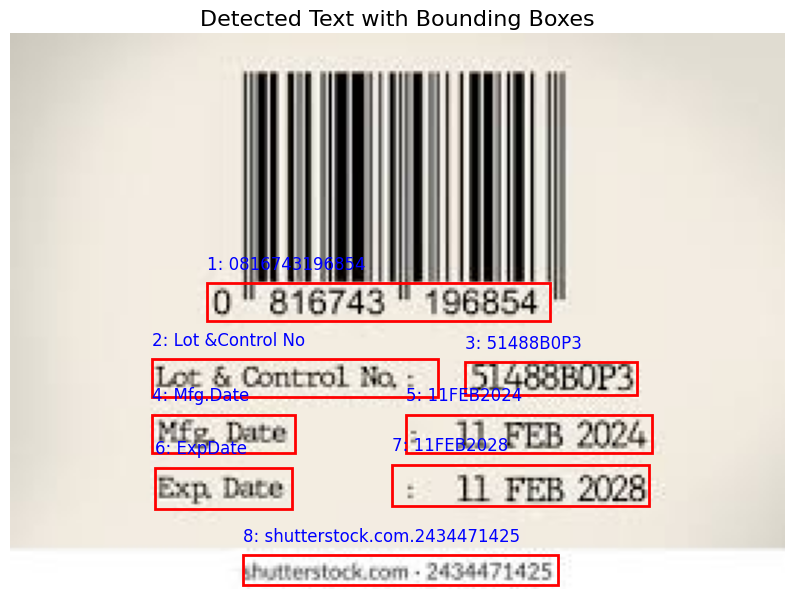

[DEBUG]  ['0816743196854', 'Lot &Control No', '51488B0P3', 'Mfg.Date', '11FEB2024', 'ExpDate', '11FEB2028', 'shutterstock.com.2434471425'] <class 'list'>
[DEBUG] combined text AC
Mfg.Date
ExpDate0816743196854
Lot &Control No
51488B0P3
Mfg.Date
11FEB2024
ExpDate
11FEB2028
shutterstock.com.2434471425

[DEBUG] Gemini Refined Output:
 Manufacturing Date: 11FEB2024
Expiration Date: 11FEB2028
MRP:  No MRP information found in the text. 

Further processing:  -1 -1 -1
[DEBUG] Showing the 'Further Processing' button.


In [ ]:
tabbed_interface.launch(debug=True)

In [ ]:
import torch
from PIL import Image
from scipy.spatial.distance import mahalanobis
import gradio as gr
import pandas as pd

# Assuming you have defined your model, feature_mean, and covariance_matrix already
# For example, you might load them like this:
# model = EfficientNet_FeatureExtractor().to(device)
# feature_mean = ...  # Your predefined mean features
# covariance_matrix = ...  # Your predefined covariance matrix

def get_banana_classification(image):
    """
    Processes the input image to classify the banana's freshness.

    Parameters:
        image: Input image in numpy array format.

    Returns:
        result: A dictionary with classification details.
    """
    # Load and transform the image
    img = Image.fromarray(image)
    img_transformed = transform(img).unsqueeze(0).to(device)

    # Feature extraction
    model = EfficientNet_FeatureExtractor().to(device)
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        features = model(img_transformed)
        features = features.view(-1)  # Flatten to 1-D

    # Calculate Mahalanobis distance
    distance = mahalanobis(features.cpu().numpy(), feature_mean.flatten(), covariance_matrix)
    distance = distance / 1e8

    # Classify based on distance
    classification_details = classify_banana_by_distance(distance)

    return classification_details  # Return the detailed classification result


def classify_banana(image):
    """
    Classifies the banana's freshness from the input image.

    Parameters:
        image: Input image in numpy array format.

    Returns:
        result: A DataFrame with classification result details.
    """
    classification_result = get_banana_classification(image)

    # Prepare the result in a DataFrame format with separate rows
    result = {
        "Attribute": [
            "Classification",
            "Freshness Index",
            "Color",
            "Dark Spots",
            "Shelf Life",
            "Ripeness Stage",
            "Texture"
        ],
        "Value": [
            classification_result.get("Classification", ""),
            classification_result.get("Freshness Index", ""),
            classification_result.get("Color", ""),
            classification_result.get("Dark Spots", ""),
            classification_result.get("Shelf Life", ""),
            classification_result.get("Ripeness Stage", ""),
            classification_result.get("Texture", "")
        ]
    }

    return pd.DataFrame(result)  # Return as a two-column DataFrame


def create_banana_classifier_interface():
    return gr.Interface(
        fn=classify_banana,
        inputs=gr.Image(type="numpy", label="Upload a Banana Image"),
        outputs=gr.DataFrame(label="Classification Result"),  # Use DataFrame for tabular output
        title="Banana Freshness Classifier",
        description="Upload an image of a banana to classify its freshness.",
        css="#component-0 { width: 300px; height: 300px; }"
    )

# Launch the interface
create_banana_classifier_interface().launch(debug=True)
